# Resultados

Plots y tests de las series de volumen y dolares generados en el notebook 001_Fixed_Threshold

In [ ]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

# Añadir el directorio raíz del proyecto al PYTHONPATH
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

import statsmodels.api as sm
import scipy.stats as stats

# Configuración de estilo de los gráficos
sns.set(style='whitegrid')
plt.rcParams.update({'font.size': 14, 'figure.figsize': (10, 6)})

In [2]:
# Importar datos
#SPY
spy_data = pd.read_parquet(r'C:\Users\adelapuente\Desktop\math_tfm\api_data\SPY_all.parquet')
spy_dollar_imb = pd.read_parquet(r'C:\Users\adelapuente\Desktop\math_tfm\imbalance_bars\SPY_dollar_imbalance.parquet')
spy_volume_imb = pd.read_parquet(r'C:\Users\adelapuente\Desktop\math_tfm\imbalance_bars\SPY_volume_imbalance.parquet')


#BTC
btc_data = pd.read_parquet(r'C:\Users\adelapuente\Desktop\math_tfm\api_data\BTC_all.parquet')
btc_dollar_imb = pd.read_parquet(r'C:\Users\adelapuente\Desktop\math_tfm\imbalance_bars\BTC_dollar_imbalance.parquet')
btc_volume_imb = pd.read_parquet(r'C:\Users\adelapuente\Desktop\math_tfm\imbalance_bars\BTC_volume_imbalance.parquet')


btc_data['date'] = pd.to_datetime(btc_data['date'])
spy_data['date'] = pd.to_datetime(spy_data['date'])

# SPY

In [3]:
# Retornos 
spy_original_log_ret = spy_data['log_returns']
spy_volume_log_ret = spy_volume_imb['log_returns']
spy_dollar_log_ret = spy_dollar_imb['log_returns']

spy_series_dict = {
    'Original': spy_original_log_ret,
    'Volume': spy_volume_log_ret,
    'Dollar': spy_dollar_log_ret
}

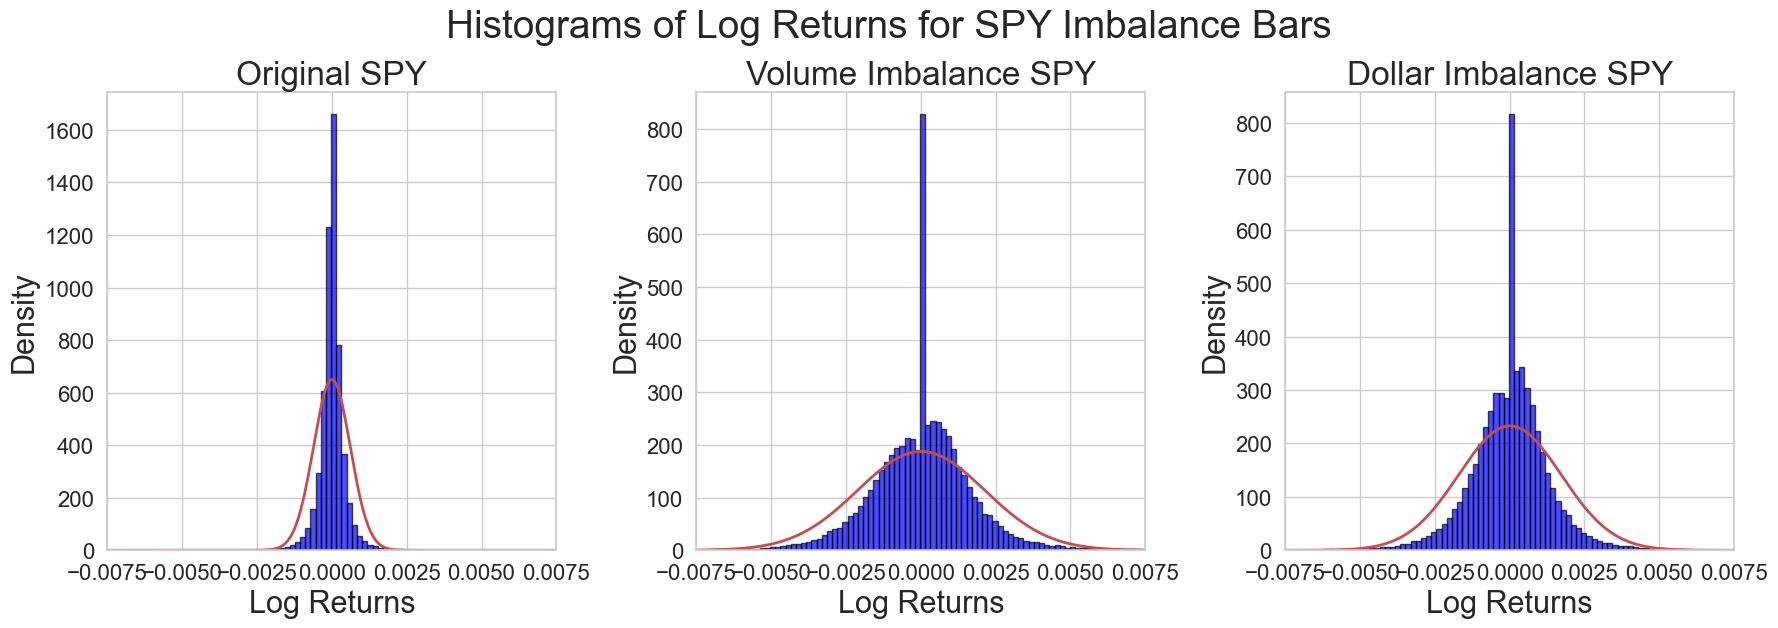

In [12]:
filename = 'SPY_histogram_comparison'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Iterar sobre las series y sus correspondientes ejes
for ax, (series_name, log_returns) in zip(axes, spy_series_dict.items()):

    count, bins, ignored = ax.hist(log_returns.dropna(), bins=1000, color='blue', edgecolor='black', alpha=0.7, density=True)
    
    mu, std = stats.norm.fit(log_returns.dropna())
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 10000)
    p = stats.norm.pdf(x, mu, std)
    
    ax.plot(x, p, 'r', linewidth=2)

    if series_name == 'Original':
        ax.set_title(f'Original SPY', fontsize=24)
    else:
        ax.set_title(f'{series_name} Imbalance SPY', fontsize=24)
 
    ax.set_xlabel('Log Returns', fontsize=22)
    ax.set_ylabel('Density', fontsize=22)
    ax.set_xlim([-0.0075, 0.0075])  

    ax.tick_params(axis='both', which='major', labelsize=16)


plt.tight_layout()
fig.suptitle('Histograms of Log Returns for SPY Imbalance Bars', fontsize=28, y=1.05)
plt.savefig('../tfm/figures/' + filename + '.png')
plt.show()

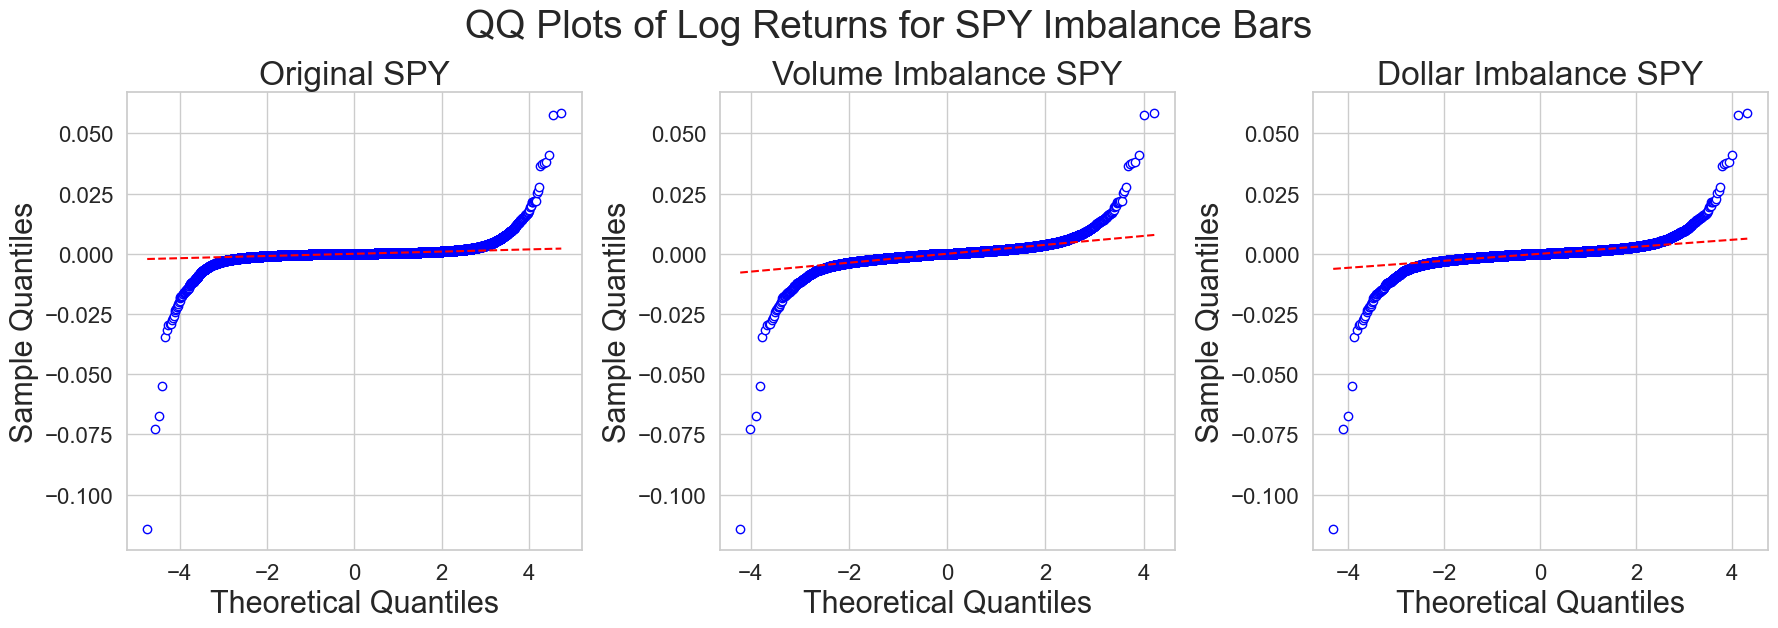

In [13]:
filename = 'SPY_qq_comparison'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (series_name, log_returns) in zip(axes, spy_series_dict.items()):

    stats.probplot(log_returns.dropna(), dist="norm", plot=ax)
    

    ax.get_lines()[1].set_color('red')
    ax.get_lines()[1].set_linestyle('--')
    ax.get_lines()[0].set_markerfacecolor('white')
    ax.get_lines()[0].set_markeredgecolor('blue')

    if series_name == 'Original':
        ax.set_title(f'Original SPY', fontsize=24)
    else:
        ax.set_title(f'{series_name} Imbalance SPY', fontsize=24)

    ax.set_xlabel('Theoretical Quantiles', fontsize=22)
    ax.set_ylabel('Sample Quantiles', fontsize=22)
    ax.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
fig.suptitle('QQ Plots of Log Returns for SPY Imbalance Bars', fontsize=28, y=1.05)
plt.savefig('../tfm/figures/' + filename + '.png')
plt.show()

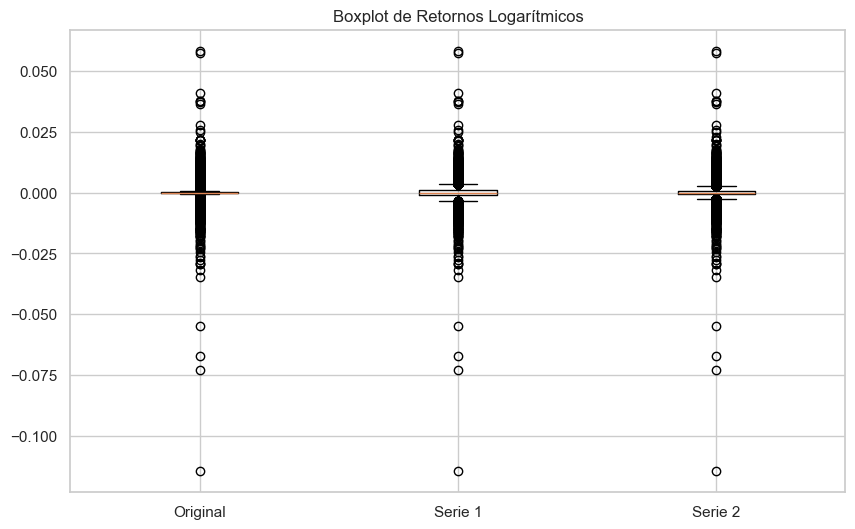

In [35]:
plt.figure(figsize=(10, 6))

data = [spy_original_log_ret, spy_volume_log_ret, spy_dollar_log_ret]
plt.boxplot(data, labels=["Original", "Serie 1", "Serie 2"])
plt.title("Boxplot de Retornos Logarítmicos")
plt.show()


In [36]:

# Diccionario para almacenar los resultados
results = {
    'Series': ['Original', 'Volume', 'Dollar'],
    'K-S Test p-value': [],
    'Anderson-Darling Statistic': [],
    'Jarque-Bera p-value': [],
    'Skewness': [],
    'Kurtosis': []
}

# Iteración sobre las series para calcular métricas y pruebas de normalidad
for series_name, series in spy_series_dict.items():
    # Prueba de Kolmogorov-Smirnov (K-S Test)
    ks_test = stats.kstest(series.dropna(), 'norm', args=(series.mean(), series.std()))
    results['K-S Test p-value'].append(ks_test.pvalue)
    
    # Prueba de Anderson-Darling
    ad_test = stats.anderson(series.dropna(), dist='norm')
    results['Anderson-Darling Statistic'].append(ad_test.statistic)
    
    # Prueba de Jarque-Bera
    jb_test = stats.jarque_bera(series.dropna())
    results['Jarque-Bera p-value'].append(jb_test.pvalue)
    
    # Asimetría (Skewness)
    skewness = stats.skew(series.dropna())
    results['Skewness'].append(skewness)
    
    # Curtosis (Kurtosis)
    kurtosis = stats.kurtosis(series.dropna()) + 3  # Añadimos 3 porque stats.kurtosis devuelve la curtosis excedente
    results['Kurtosis'].append(kurtosis)

# Convertir los resultados en un DataFrame para mejor visualización
results_df = pd.DataFrame(results)

# Mostrar los resultados
results_df

,Series,K-S Test p-value,Anderson-Darling Statistic,Jarque-Bera p-value,Skewness,Kurtosis
0,Original,0.0,46037.023246,0.0,-11.832312,2981.959966
1,Volume,0.0,1553.586255,0.0,-3.462969,249.678449
2,Dollar,0.0,2947.144008,0.0,-4.247190,383.733956


## BTC

In [15]:
# Retornos 
btc_original_log_ret = btc_data['log_returns']
btc_volume_log_ret = btc_volume_imb['log_returns']
btc_dollar_log_ret = btc_dollar_imb['log_returns']

btc_series_dict = {
    'Original': btc_original_log_ret,
    'Volume': btc_volume_log_ret,
    'Dollar': btc_dollar_log_ret
}

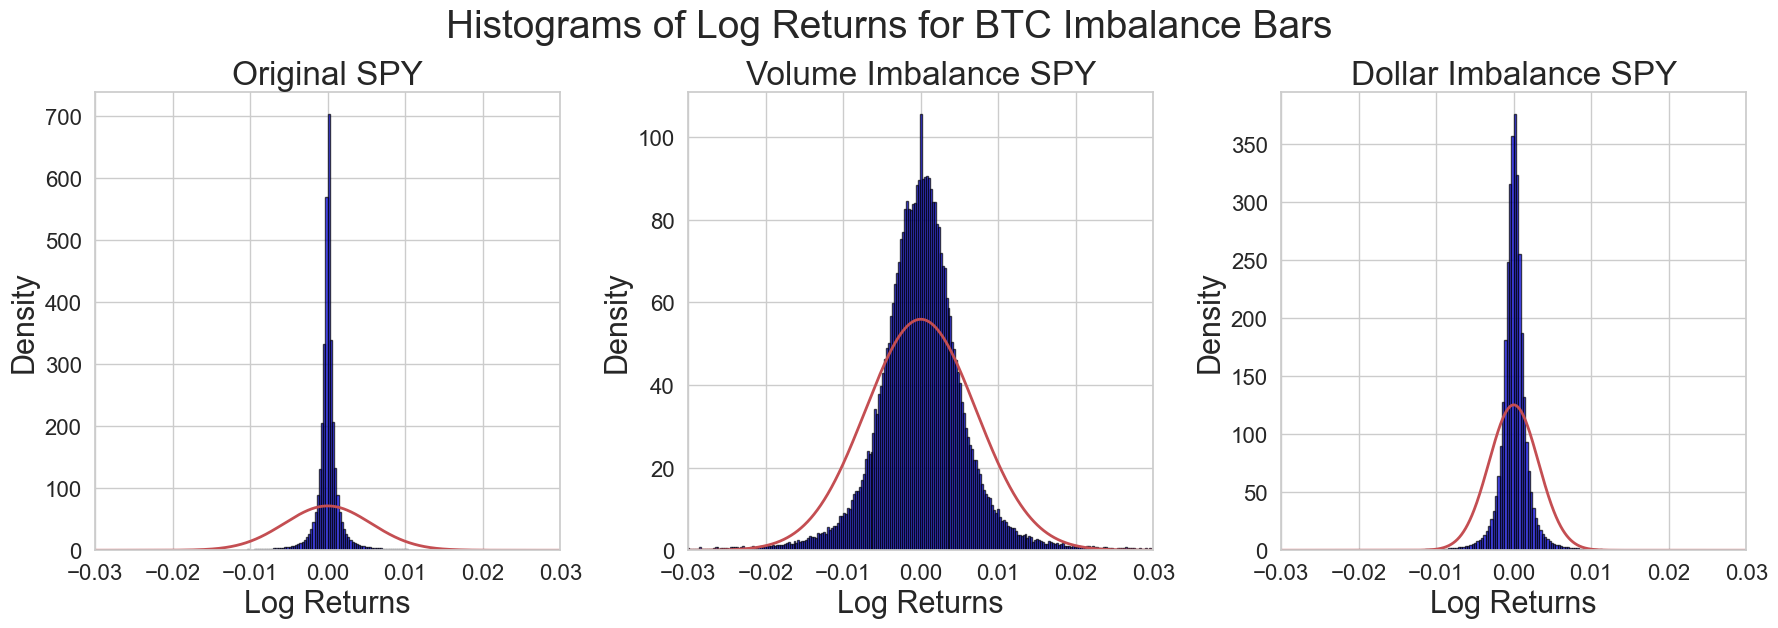

In [16]:
filename = 'BTC_histogram_comparison'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Iterar sobre las series y sus correspondientes ejes
for ax, (series_name, log_returns) in zip(axes, btc_series_dict.items()):

    count, bins, ignored = ax.hist(log_returns.dropna(), bins=1000, color='blue', edgecolor='black', alpha=0.7, density=True)
    
    mu, std = stats.norm.fit(log_returns.dropna())
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 10000)
    p = stats.norm.pdf(x, mu, std)
    
    ax.plot(x, p, 'r', linewidth=2)
    
    if series_name == 'Original':
        ax.set_title(f'Original SPY', fontsize=24)
    else:
        ax.set_title(f'{series_name} Imbalance SPY', fontsize=24)

    ax.set_xlabel('Log Returns', fontsize=22)
    ax.set_ylabel('Density', fontsize=22)
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    ax.set_xlim([-0.03, 0.03])  

# Ajustar el layout para que no se sobrepongan las etiquetas
plt.tight_layout()
fig.suptitle('Histograms of Log Returns for BTC Imbalance Bars', fontsize=28, y=1.05)
plt.savefig('../tfm/figures/' + filename + '.png')
plt.show()

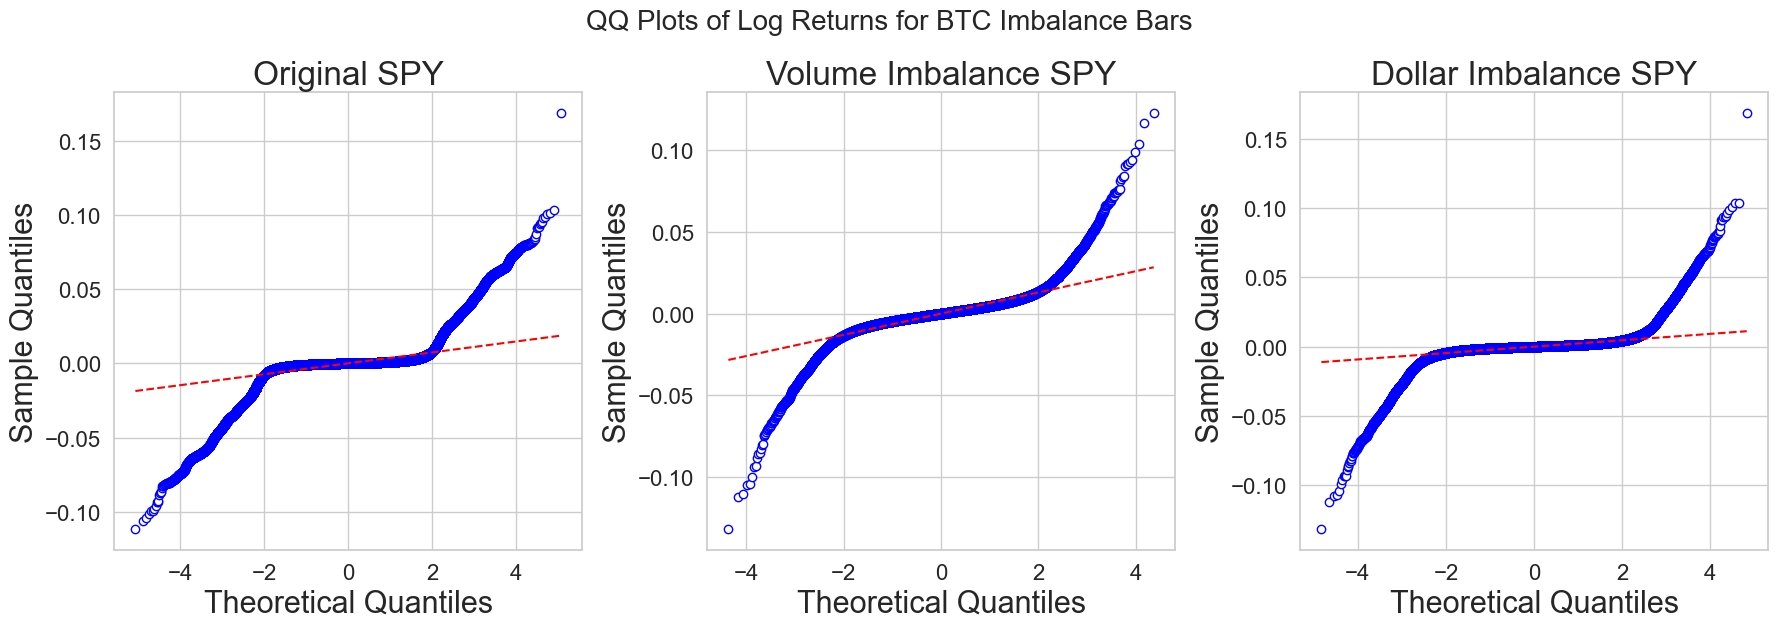

In [17]:
filename = 'BTC_qq_comparison'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, (series_name, log_returns) in zip(axes, btc_series_dict.items()):

    stats.probplot(log_returns.dropna(), dist="norm", plot=ax)
    

    ax.get_lines()[1].set_color('red')
    ax.get_lines()[1].set_linestyle('--')
    ax.get_lines()[0].set_markerfacecolor('white')
    ax.get_lines()[0].set_markeredgecolor('blue')

    if series_name == 'Original':
        ax.set_title(f'Original SPY', fontsize=24)
    else:
        ax.set_title(f'{series_name} Imbalance SPY', fontsize=24)
    ax.set_xlabel('Theoretical Quantiles', fontsize=22)
    ax.set_ylabel('Sample Quantiles', fontsize=22)
    ax.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
fig.suptitle('QQ Plots of Log Returns for BTC Imbalance Bars', fontsize=20, y=1.05)
plt.savefig('../tfm/figures/' + filename + '.png')
plt.show()

In [60]:

# Diccionario para almacenar los resultados
results = {
    'Asset': [],
    'Series': [],
    'K-S Test p-value': [],
    'Anderson-Darling Statistic': [],
    'Jarque-Bera p-value': [],
    'Skewness': [],
    'Kurtosis': []
}

for asset_name, series_dict in [('SPY', spy_series_dict), ('BTC', btc_series_dict)]:

    for series_name, series in series_dict.items():
 
        results['Asset'].append(asset_name)
        results['Series'].append(series_name)

        # Prueba de Kolmogorov-Smirnov (K-S Test)
        ks_test = stats.kstest(series.dropna(), 'norm', args=(series.mean(), series.std()))
        results['K-S Test p-value'].append(ks_test.pvalue)
        
        # Prueba de Anderson-Darling
        ad_test = stats.anderson(series.dropna(), dist='norm')
        results['Anderson-Darling Statistic'].append(ad_test.statistic)
        
        # Prueba de Jarque-Bera
        jb_test = stats.jarque_bera(series.dropna())
        results['Jarque-Bera p-value'].append(jb_test.pvalue)
        
        # Asimetría (Skewness)
        skewness = stats.skew(series.dropna())
        results['Skewness'].append(skewness)
        
        # Curtosis (Kurtosis)
        kurtosis = stats.kurtosis(series.dropna()) + 3  # Añadimos 3 porque stats.kurtosis devuelve la curtosis excedente
        results['Kurtosis'].append(kurtosis)


results_df = pd.DataFrame(results)
results_df


,Asset,Series,K-S Test p-value,Anderson-Darling Statistic,Jarque-Bera p-value,Skewness,Kurtosis
0,SPY,Original,0.0,46037.023246,0.0,-11.832312,2981.959966
1,SPY,Volume,0.0,1553.586255,0.0,-3.462969,249.678449
2,SPY,Dollar,0.0,2947.144008,0.0,-4.247190,383.733956
3,BTC,Original,0.0,646407.274062,0.0,0.012876,44.689323
4,BTC,Volume,0.0,3131.357980,0.0,-0.026348,26.131920
5,BTC,Dollar,0.0,97255.289974,0.0,0.070029,139.588924
